In [3]:
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.analysis_tools import PackedSelection
import awkward as ak
import os
import logging
import shutil
import hist
import json
import numpy as np
from coffea.lumi_tools import LumiMask
from coffea import processor
from Snip_debug import *
import crossSections
from coffea import util
import matplotlib.pyplot as plt
import mplhep as hep

In [4]:
    class Loadfileset():
        def __init__(self, jsonfilename) :
            with open(jsonfilename) as f :
                self.handler = json.load(f)
    
        
        def Show(self , verbosity=1):
            if verbosity==1 :
                for key, value in self.handler.items() :
                        rich.print(key+" : ", list(value.keys()))
            elif verbosity==2 :
                for key, value in self.handler.items() :
                        rich.print(key+" : ", list(value.keys()), "\n")
                        for subkey , subvalue in value.items() :
                            rich.print("\t"+subkey+" : ")
                            for file in subvalue :
                                rich.print("\t", file)
            elif verbosity==3 :
                for key, value in self.handler.items() :
                        rich.print(key+" : ", list(value.keys()), "\n")
                        for subkey , subvalue in value.items() :
                            rich.print("\t"+subkey+" : ")
                            for subsubkey, subsubvalue in subvalue.items() :
                                try :
                                    for file in subvalue :
                                        rich.print("\t", file)
                                except:
                                    rich.print("\t"+subsubkey+" : ")
        
        def getFileset(self, mode ,superkey, key, redirector ) :
            if redirector=="fnal":
                redirector_string = "root://cmsxrootd.fnal.gov//"
            elif redirector=="infn":
                redirector_string = "root://xrootd-cms.infn.it//"
            elif redirector=="wisc":
                redirector_string = "root://pubxrootd.hep.wisc.edu//"
            elif redirector=="unl":
                redirector_string = "root://xrootd-local.unl.edu:1094//"
            elif redirector=="kisti":
                redirector_string = "root://cms-xrdr.sdfarm.kr:1094//xrd//"
            raw_fileset = self.handler[mode][superkey][key] 
            requested_fileset = {superkey : [redirector_string+filename for filename in raw_fileset]}
            return requested_fileset
        
        def getraw(self):
            #load the raw dictionary
            full_fileset = self.handler
            return full_fileset
def getDataset(keymap, load=True, dict = None, files=None, begin=0, end=0, mode = "sequential"):
        #Warning : Never use 'files' with 'begin' and 'end'
        fileset = Loadfileset("newfileset.json")
        fileset_dict = fileset.getraw()
        MCmaps = [
            "MET_Run2018",
            "ZJets_NuNu",
            "TTToSemiLeptonic",
            "TTTo2L2Nu",
    	"TTToHadronic",
            "WJets_LNu",
            "DYJets_LL",
            "VV",
            "QCD",
            "ST"
            ]
    
        
        runnerfileset = buildFileset(fileset_dict[keymap],"commonfs")
        flat_list={}
        flat_list[keymap] = []
    
        if mode == "sequential":
            if end - begin <= 0:
                print("Invalid begin and end values.\nFalling back to full dataset...")
                outputfileset = runnerfileset
            else:
                # for key in runnerfileset.keys() :
                #     flat_list[keymap] += runnerfileset[key]
                #indexer
                index={}
                i = 1
                for key in runnerfileset.keys() :
                    index[key] = []
                    for file in runnerfileset[key] :
                        index[key].append(i)
                        i += 1
    
                accept = np.arange(begin,end+1,1)
                print(accept)
                temp = {}
                for key in runnerfileset.keys() :
                    temp[key] = []
                    for i in range(len(runnerfileset[key])) :
                        if index[key][i] in accept :
                            temp[key].append(runnerfileset[key][i])
                #outputfileset = {keymap : flat_list[keymap][(begin - 1) :end]}
                #outputfileset = {keymap : temp}
                outputfileset = temp
        elif mode == "divide" :
            if files == None:
                print("Invalid number of files.\nFalling back to full dataset...")
                outputfileset = runnerfileset
            else:
                # Divide the share of files from all the 8 categories of ZJets_NuNu
                file_number = 0
                while file_number < files :
                    for key in runnerfileset.keys():
                        if file_number >= files :
                            break
                        flat_list[keymap] += [runnerfileset[key][0]]
                        runnerfileset[key] = runnerfileset[key][1:]
                        file_number += 1
                outputfileset = {keymap : flat_list[keymap]}
        else:
            print("Invalid mode of operation", mode)
            raise KeyError
        
        print("Running ", np.array([len(value) for value in outputfileset.values()]).sum(), " files...")
        return outputfileset
def buildFileset(dict , redirector):
        '''
        To return a run-able dict with the appropriate redirector.
        Please input a dictionary which is only singly-nested
        '''
        redirectors = {
            "fnal": "root://cmsxrootd.fnal.gov//",
            "infn": "root://xrootd-cms.infn.it//",
            "wisc": "root://pubxrootd.hep.wisc.edu//",
            "unl":  "root://xrootd-local.unl.edu:1094/",
            "kisti": "root://cms-xrdr.sdfarm.kr:1094//xrd/",
            "hdfs": "/hdfs",
            "commonfs": "/commonfs"
    
        }
    
        if (redirector=="fnal") | (redirector==1) :
            redirector_string = redirectors["fnal"]
        elif (redirector=="infn") | (redirector==2) :
            redirector_string = redirectors["infn"]
        elif (redirector=="wisc") | (redirector==3):
            redirector_string = redirectors["wisc"]
        elif (redirector=="unl") | (redirector==4):
            redirector_string = redirectors["unl"]
        elif (redirector=="kisti") | (redirector==5):
            redirector_string = redirectors["kisti"]
        elif (redirector=="hdfs") | (redirector==6):
            redirector_string = redirectors["hdfs"]
        elif (redirector=="commonfs") | (redirector==7):
            redirector_string = redirectors["commonfs"]
    
        temp = dict 
        output = {}
        for key in temp.keys() :
            try :
                g = temp[key]
                if isinstance(g,list):
                    templist = []
                    for filename in g :
                        filename = filename[filename.find("/store/") :]
                        templist.append(redirector_string+filename)
                    output[key] = templist
            except :
                raise KeyError
        return output

In [5]:
def get_lumiobject():
    path = "Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt" 
    return LumiMask(path)

lumimaskobject = get_lumiobject()

def lumi(events,cutflow,path="",lumiobject=None):
    #Selecting use-able events
    if lumiobject==None :
        #path_of_file = path+"Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.json"
        path_of_file = path+"golden.json"
        lumimask = LumiMask(path_of_file)
    else :
        lumimask = lumiobject
    events = events[lumimask(events.run, events.luminosityBlock)]
    cutflow["lumimask"] = len(events)
    return events , cutflow

In [9]:
run_at = "futures"
beginat = 40
endat = 44
nworkers = 16
chunk_size = 500000
def zip_files(list_of_files):
        os.makedirs("temporary_folder")
        for file in list_of_files :
            shutil.copy(file,"temporary_folder")
        archive_name = "helper_files"
        shutil.make_archive(archive_name,"zip","temporary_folder")
        shutil.rmtree("temporary_folder")
        return archive_name+".zip"
#For futures execution
if run_at == "futures" :
    files = getDataset(keymap="MET_Run2018",load=True, mode="sequential", begin=beginat, end=endat)
    futures_run = processor.Runner(
        executor = processor.FuturesExecutor(workers=nworkers),
        schema=NanoAODSchema,
        chunksize=chunk_size ,
        xrootdtimeout=120
    )
    Output = futures_run(
        files,
        "Events",
        processor_instance=Top_mu(category="resolved",helper_objects=[lumimaskobject])
    )

#For dask execution
elif run_at == "dask" :
    from dask.distributed import Client , LocalCluster
    cluster = LocalCluster()
    client = Client(cluster)
    print("scheduler at ", client.scheduler.address)
    cluster.scale(nworkers)

    client.upload_file(zip_files(
        [
            "MonoHiggstobb/Debug/control/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt",
            "MonoHiggstobb/Debug/control/Snip_debug.py"
            ]
        )
        )
    with open("MonoHiggstobb/Debug/control/newfileset.json") as f: #load the fileset
        filedict = json.load(f)
    files = getDataset(keymap="MET_Run2018",load=True, mode="sequential", begin=begin_at, end=end_at)
    dask_run = processor.Runner(
        executor = processor.DaskExecutor(client=client),
        schema=NanoAODSchema,
        chunksize= chunk_size
    )
    Output = dask_run(
        files,
        "Events",
        processor_instance=Top_mu(category="resolved",helper_objects=[lumimaskobject])
    )

[40 41 42 43 44]
Running  5  files...


Output()

Output()

In [14]:
try :
    output_file = f"CR_resolved_Top_MET_Run2018_from_{beginat}_to_{endat}.coffea"
    pass
except :
    output_file = f"CR_{inputs.cat}_Top_{inputs.keymap}.coffea"
print("Saving the output to : " , output_file)
util.save(output= Output, filename="coffea_files/"+output_file)
print(f"File {output_file} saved.")

Saving the output to :  CR_resolved_Top_MET_Run2018_from_40_to_44.coffea
File CR_resolved_Top_MET_Run2018_from_40_to_44.coffea saved.


In [15]:
for key in Output.keys():
    print(Output[key]['MET_Run2018']['MET_Run2018B']['Cutflow'])


{'Total events': 8702273, 'MET trigger': 4414798, 'MET filters': 4004689, 'no electrons': 3938972, 'no taus': 3907400, 'no photons': 3873409, 'HEM veto': 3872926, 'one_tight_muon': 143371, 'MET > 50.0 GeV': 112966, 'Recoil': 30360, 'leading jet pt > 50': 3631, 'subleading jet pt > 30': 2637, 'pt(bb) > 100': 1672, '70 < M_bb < 150': 497, 'At least one normal additional jet': 469}
{'Total events': 8702273, 'MET trigger': 4414798, 'MET filters': 4004689, 'no electrons': 3938972, 'no taus': 3907400, 'no photons': 3873409, 'HEM veto': 3872926, 'one_tight_muon': 143371, 'MET > 50.0 GeV': 112966, 'Recoil': 11521, 'leading jet pt > 50': 1505, 'subleading jet pt > 30': 1128, 'pt(bb) > 100': 766, '70 < M_bb < 150': 203, 'At least one normal additional jet': 195}
{'Total events': 8702273, 'MET trigger': 4414798, 'MET filters': 4004689, 'no electrons': 3938972, 'no taus': 3907400, 'no photons': 3873409, 'HEM veto': 3872926, 'one_tight_muon': 143371, 'MET > 50.0 GeV': 112966, 'Recoil': 8441, 'leadi

Total events  :  8.702273e+06  

MET trigger  :  4.414798e+06  

MET filters  :  4.004689e+06  

no electrons  :  3.938972e+06  

no taus  :  3.907400e+06  

no photons  :  3.873409e+06  

HEM veto  :  3.872926e+06  

one_tight_muon  :  1.433710e+05  

MET > 50.0 GeV  :  1.129660e+05  

Recoil  :  5.566000e+04  

leading jet pt > 50  :  6.844000e+03  

subleading jet pt > 30  :  5.042000e+03  

pt(bb) > 100  :  3.375000e+03  

70 < M_bb < 150  :  9.220000e+02  

At least one normal additional jet  :  8.790000e+02  



/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: divide by zero encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: divide by zero encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_17966/2557961388.py:90: Runtime

ValueError: operands could not be broadcast together with shapes (18,) (25,) 

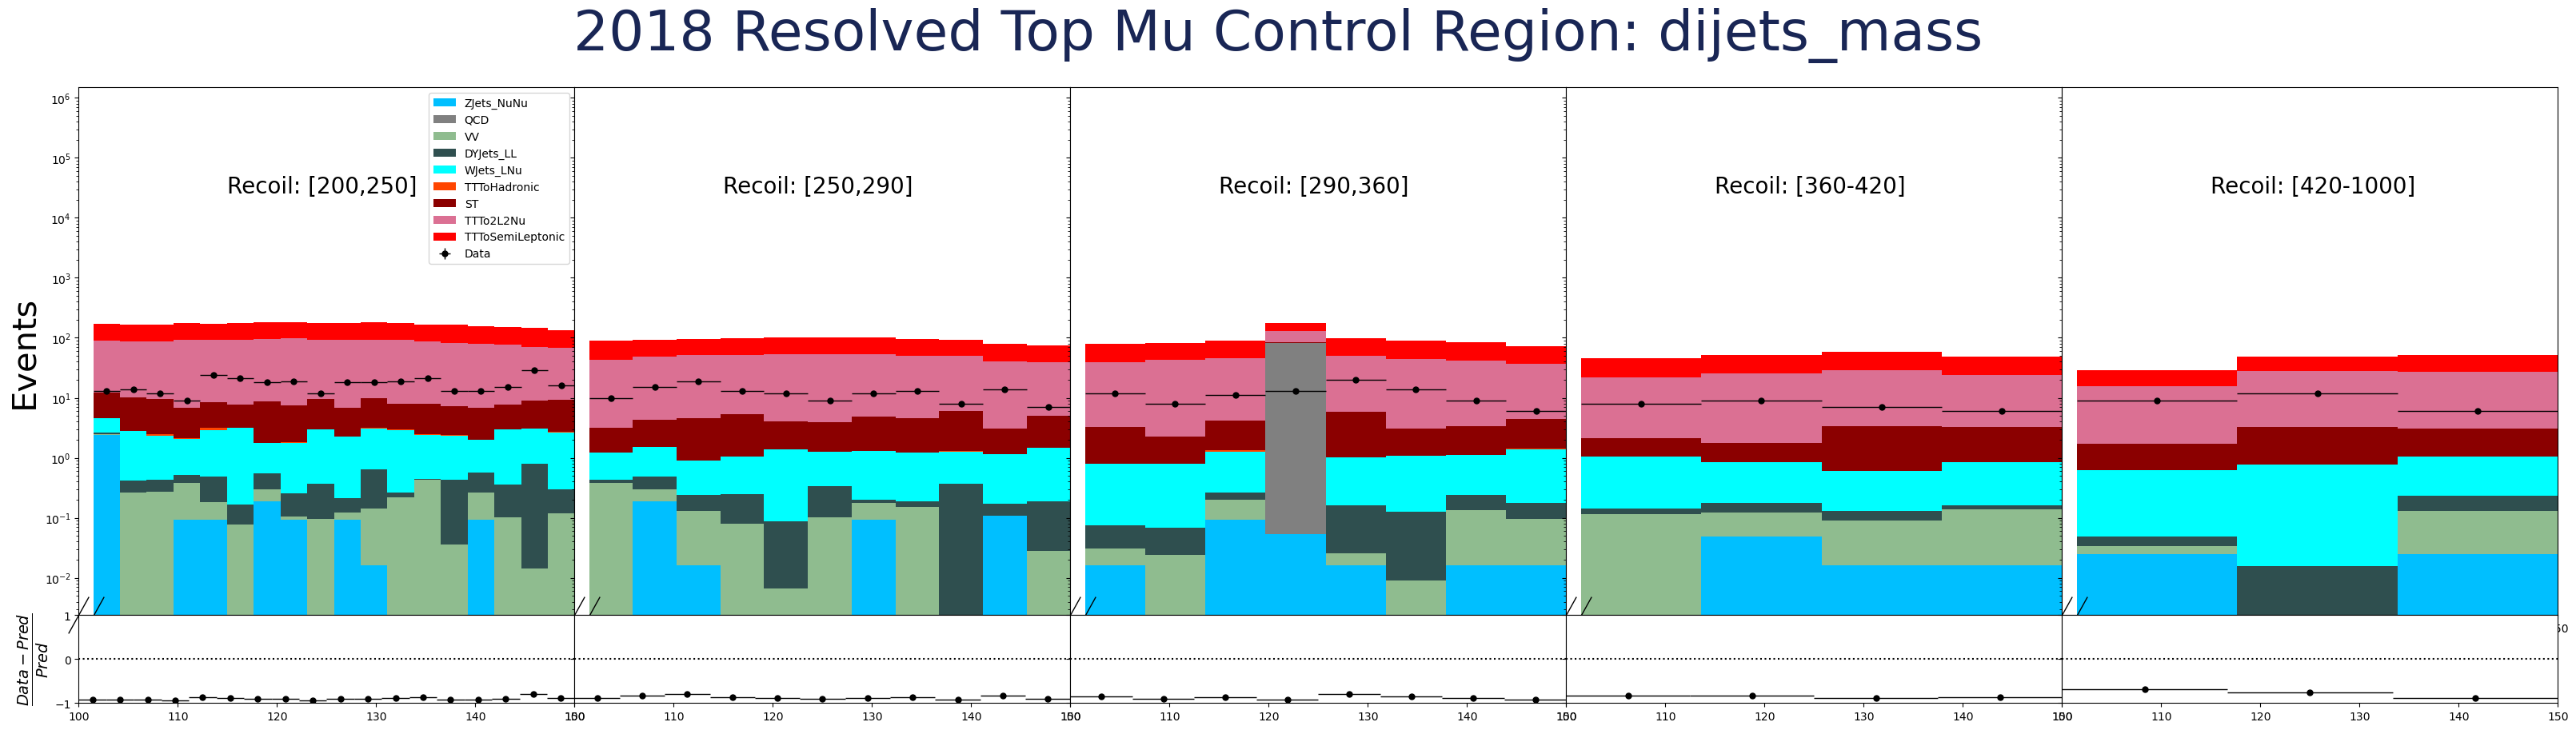

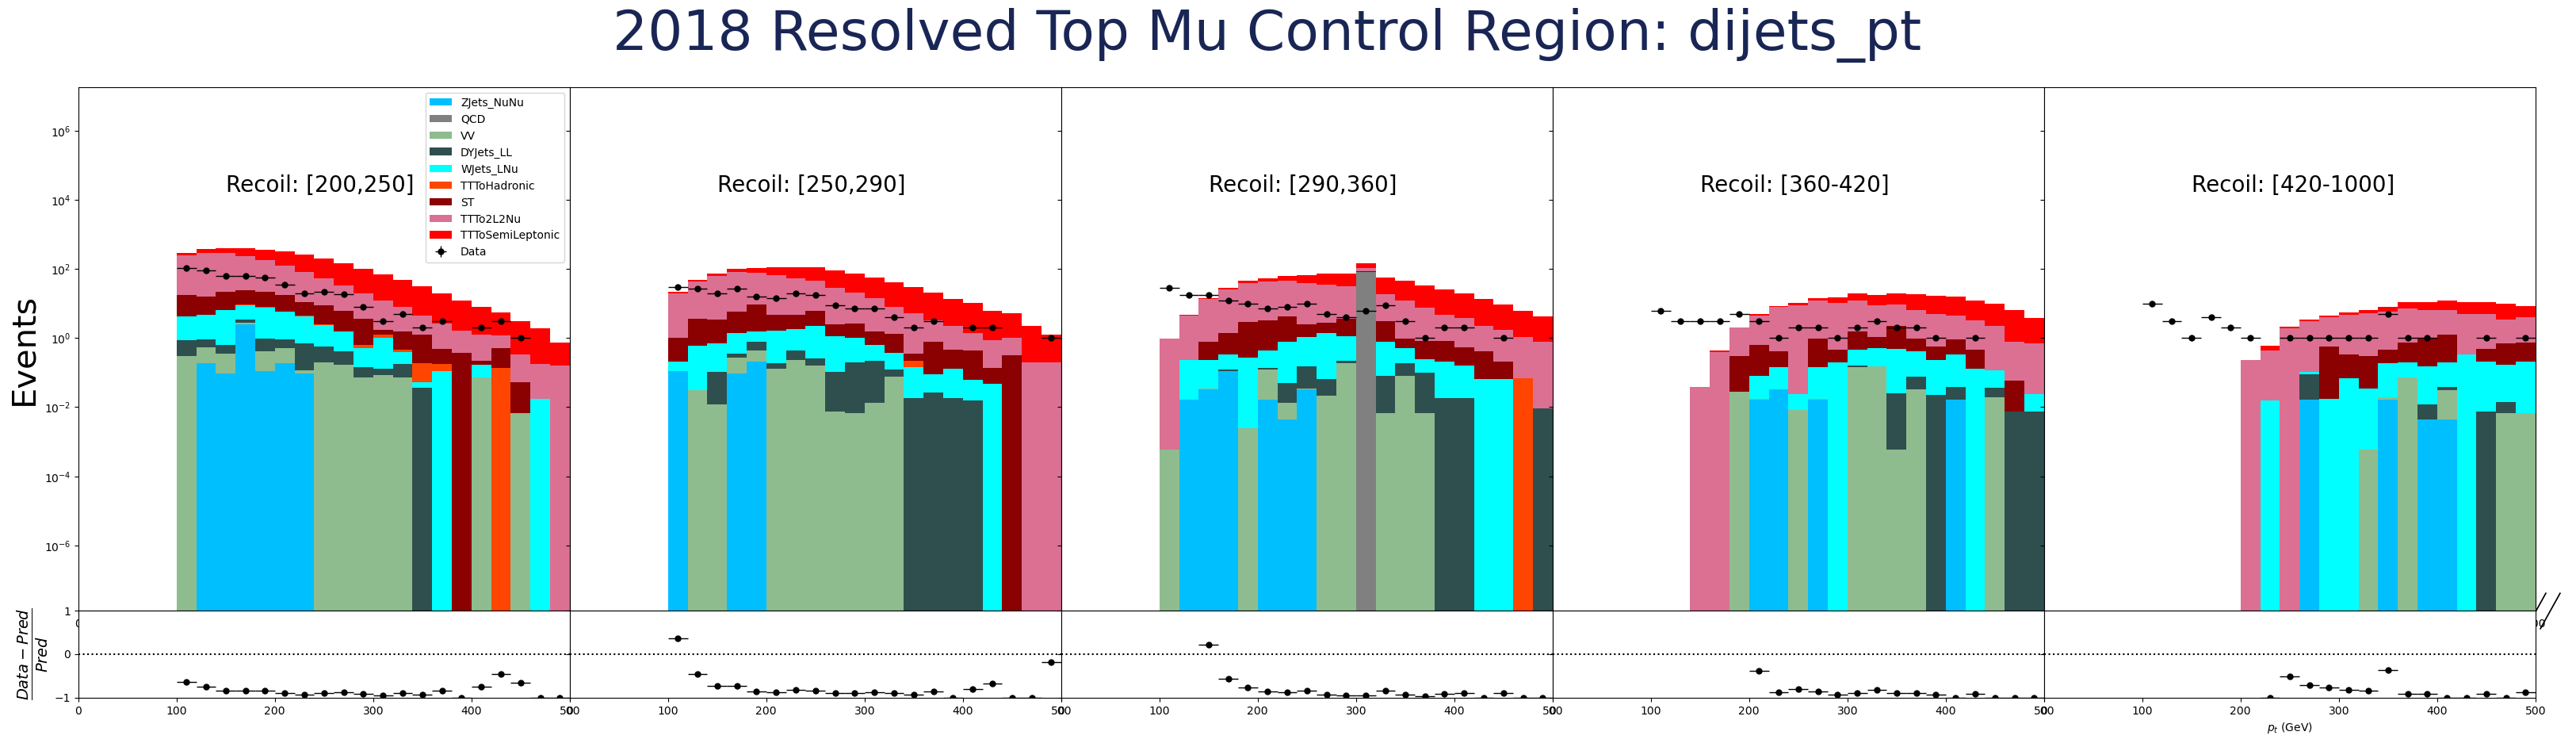

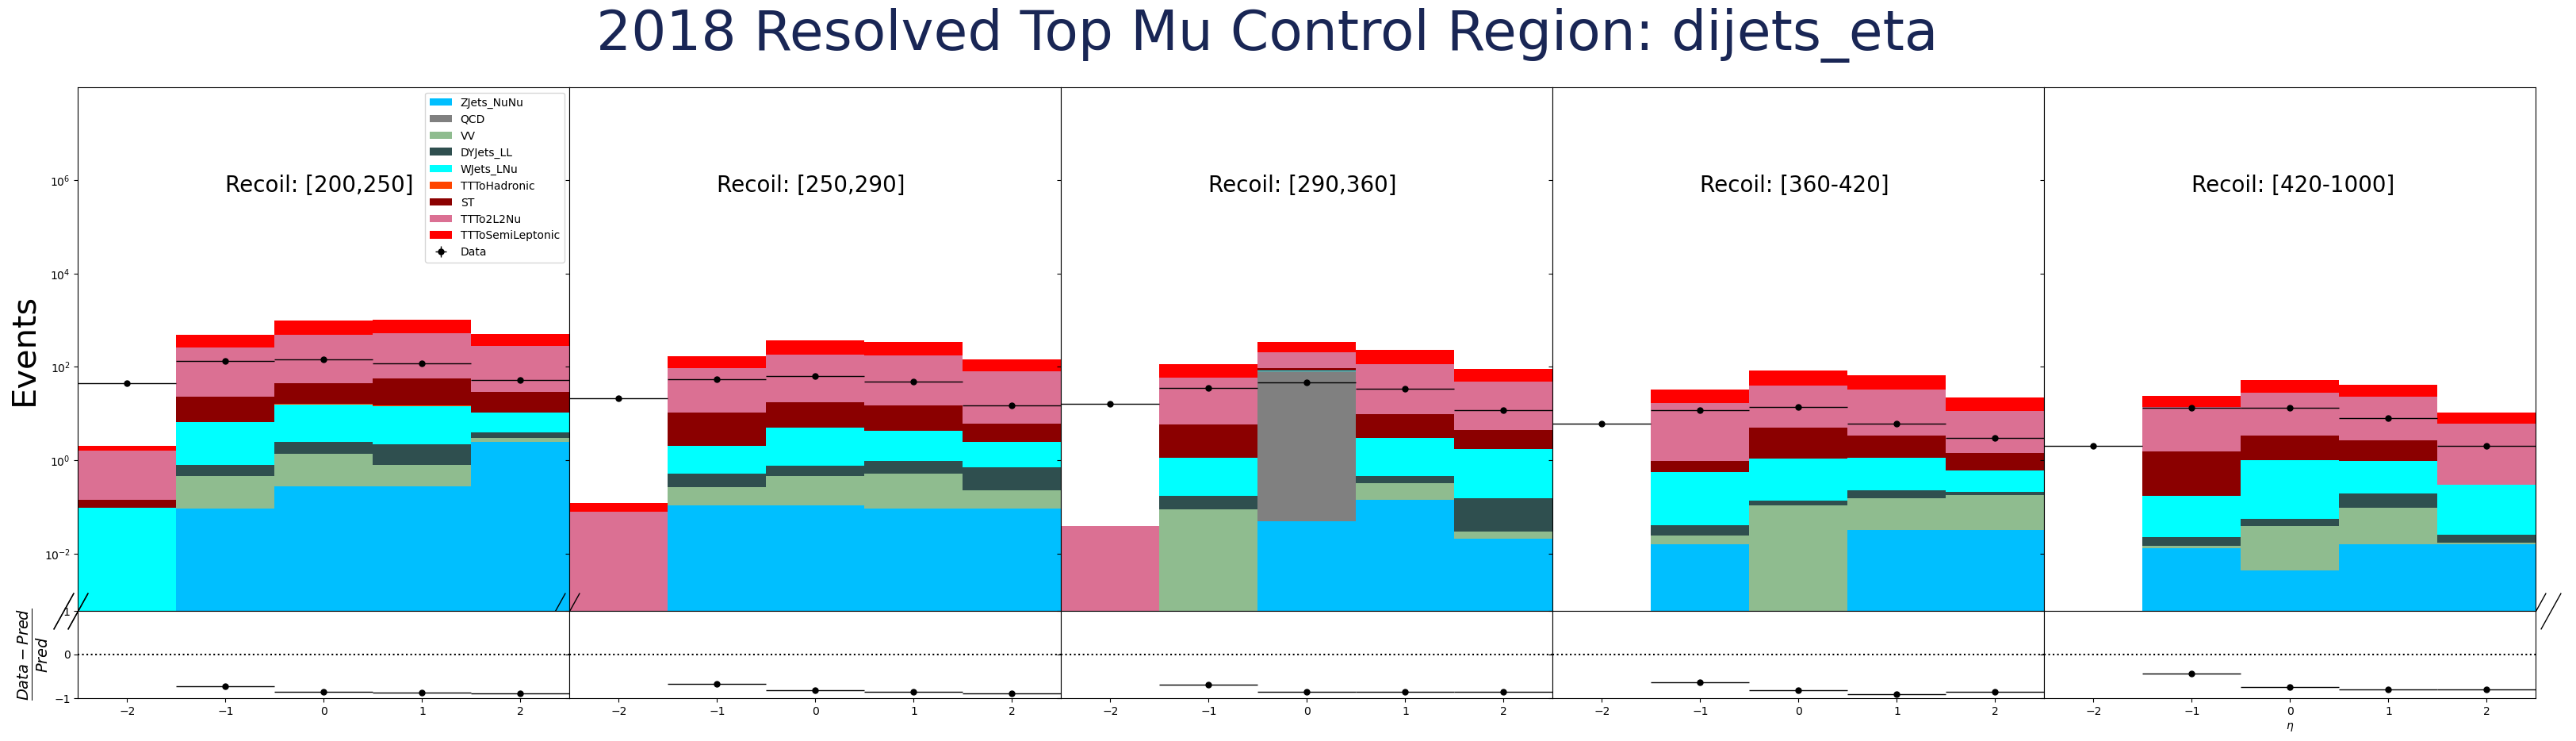

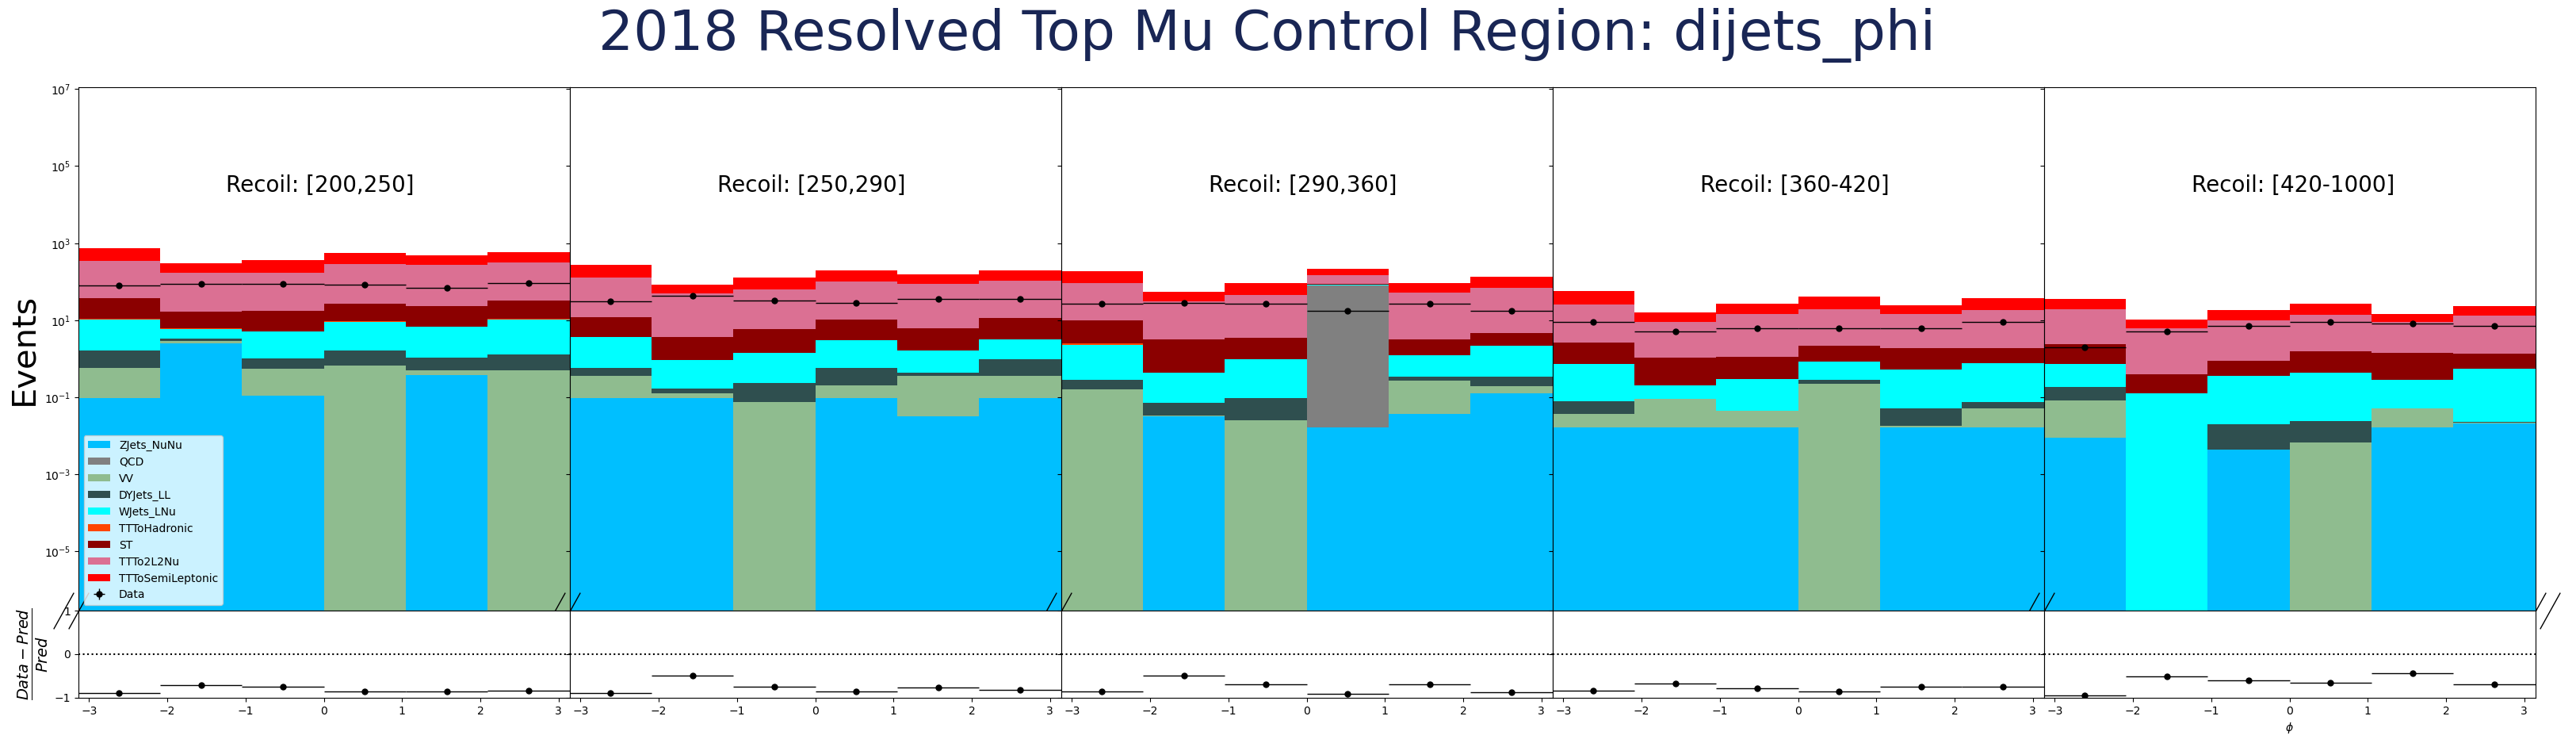

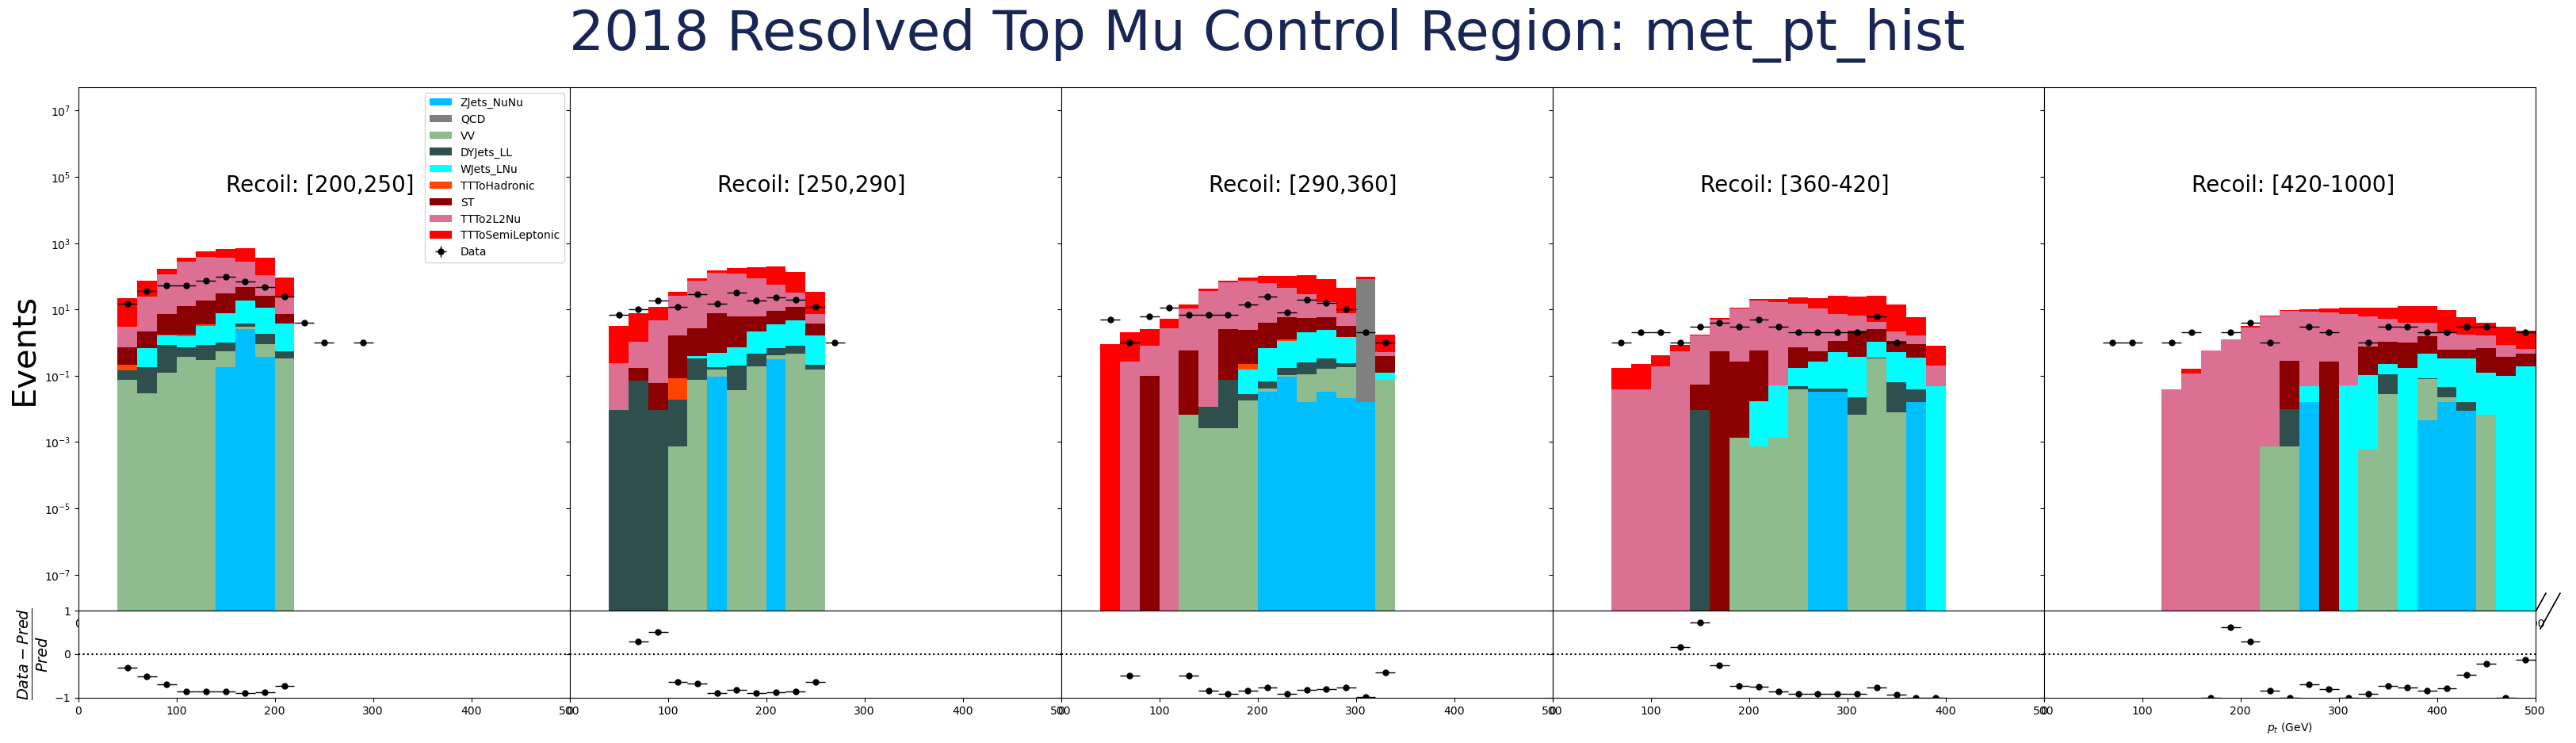

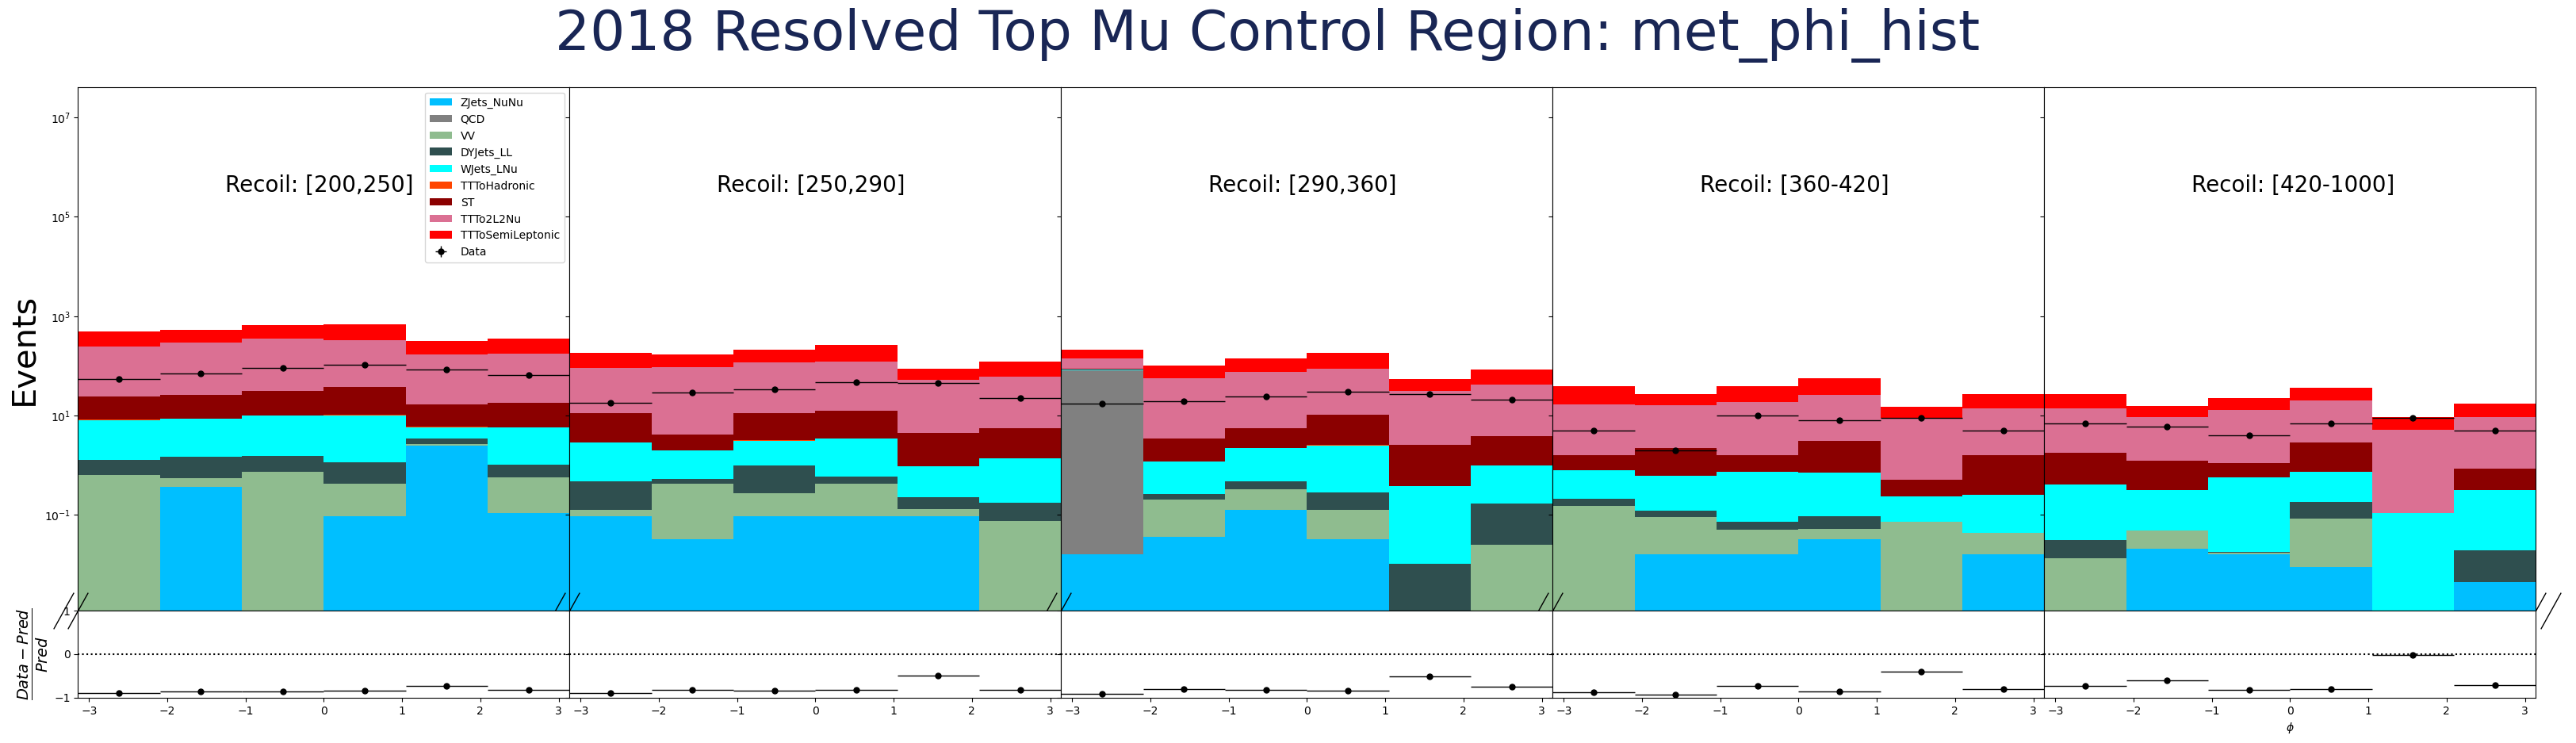

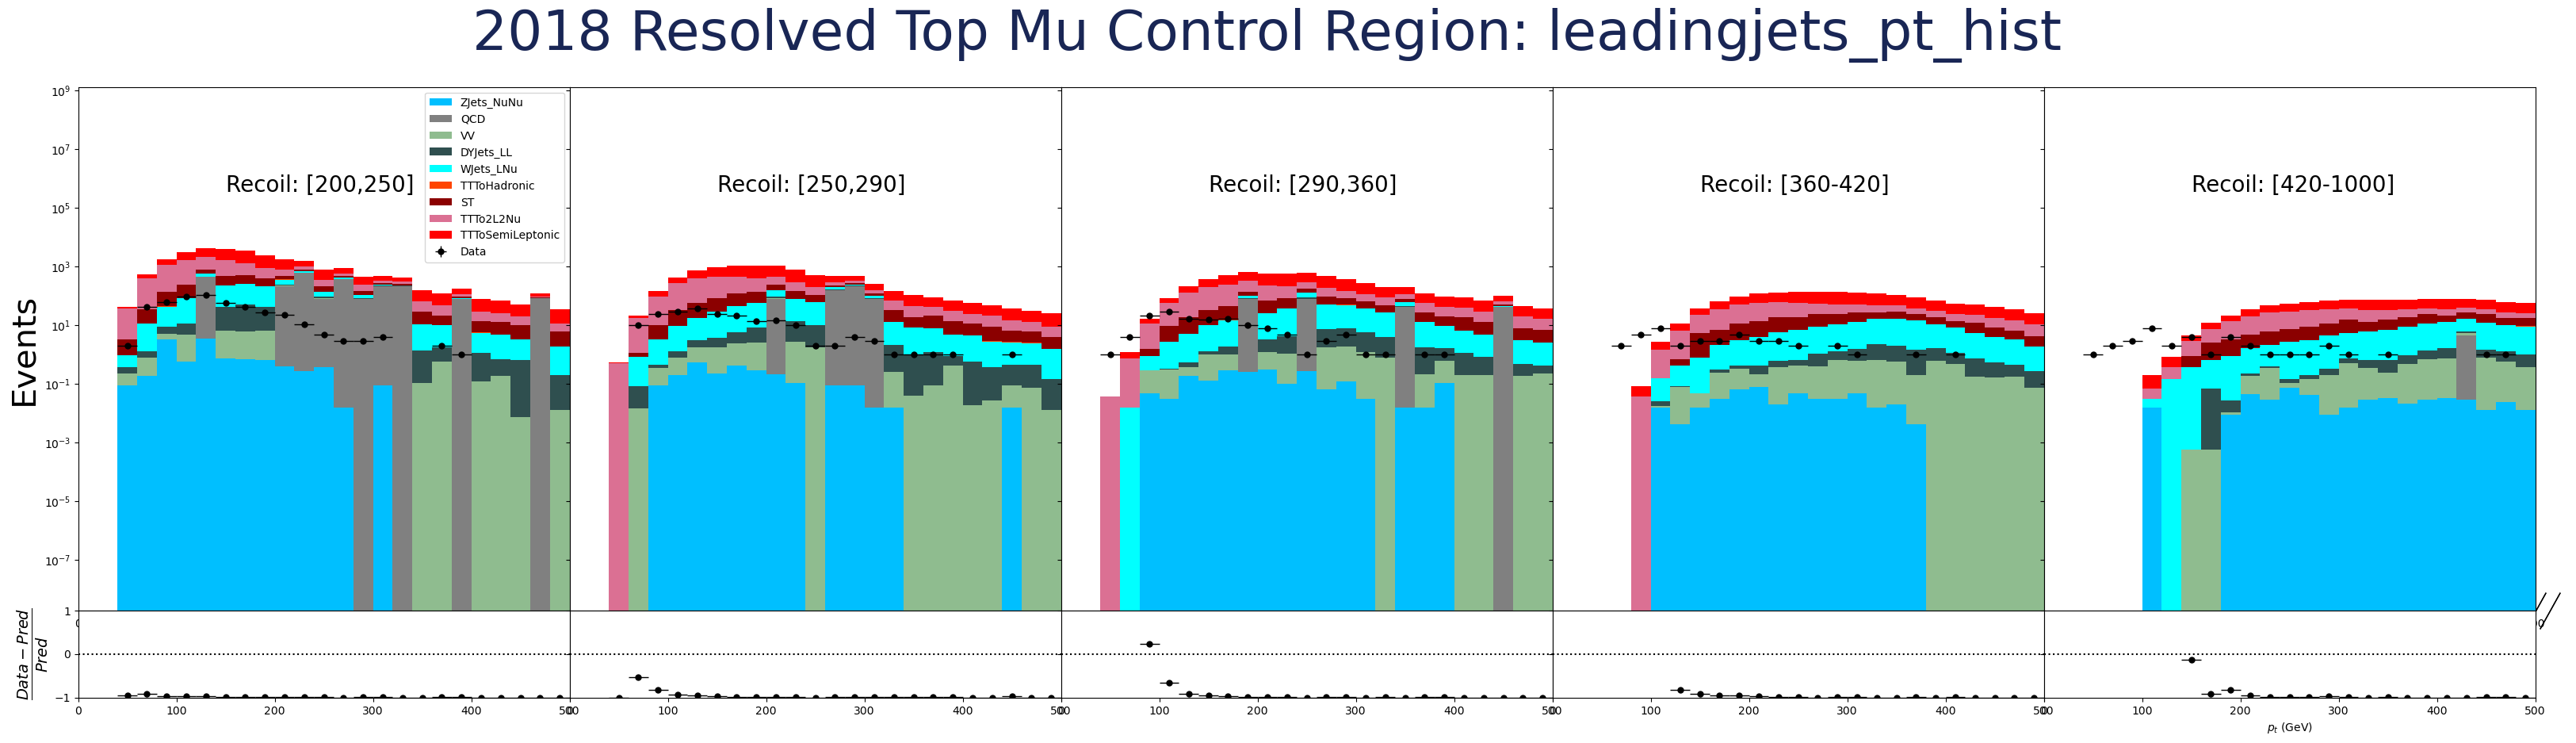

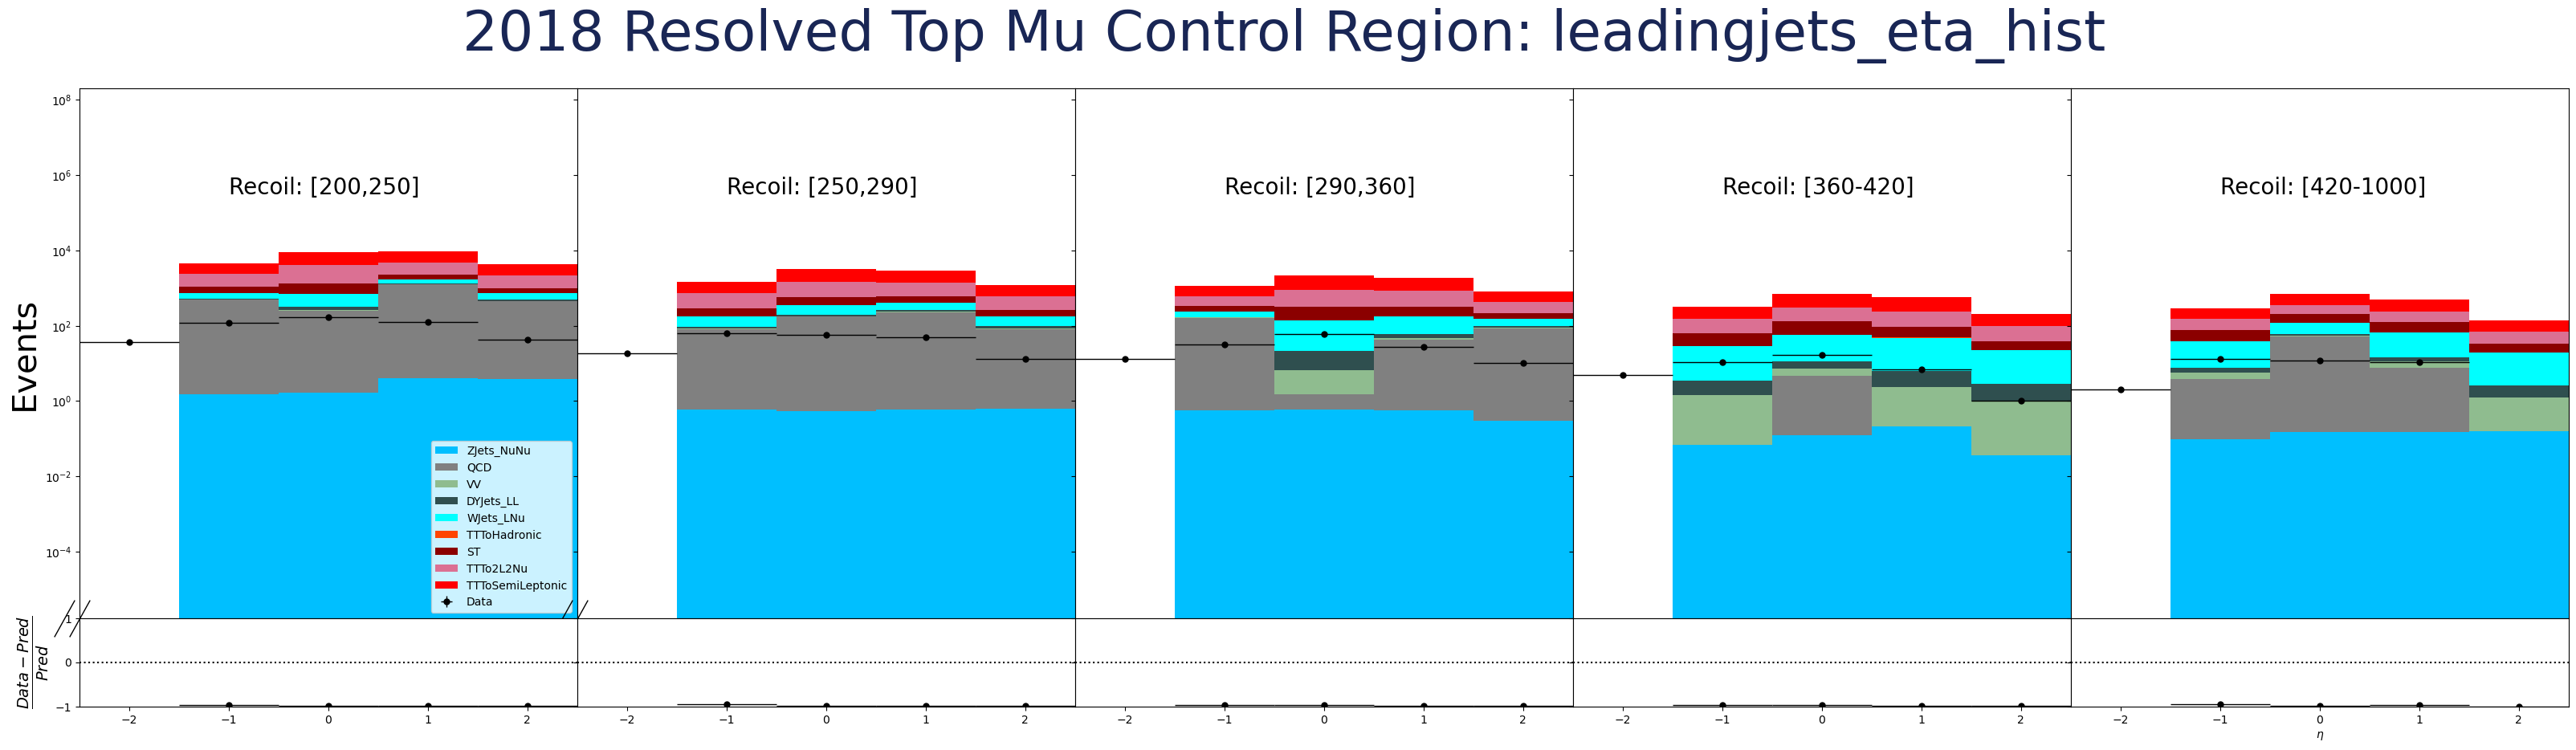

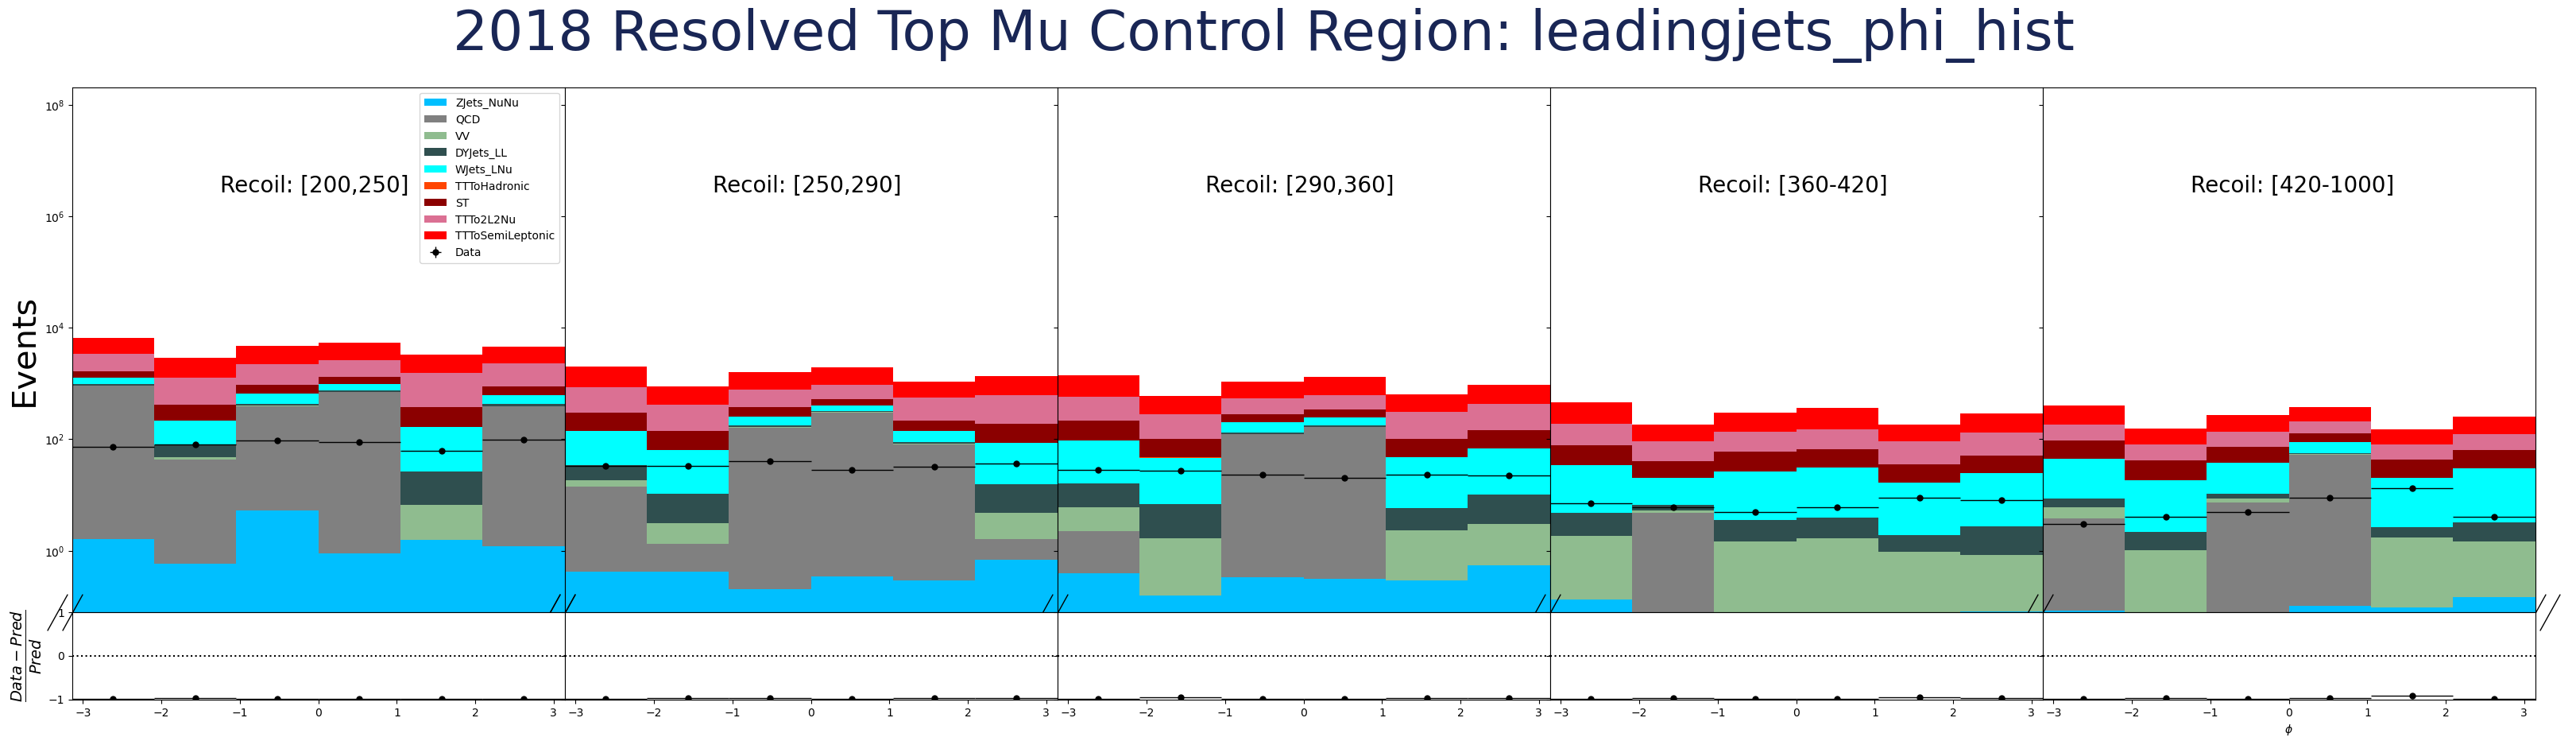

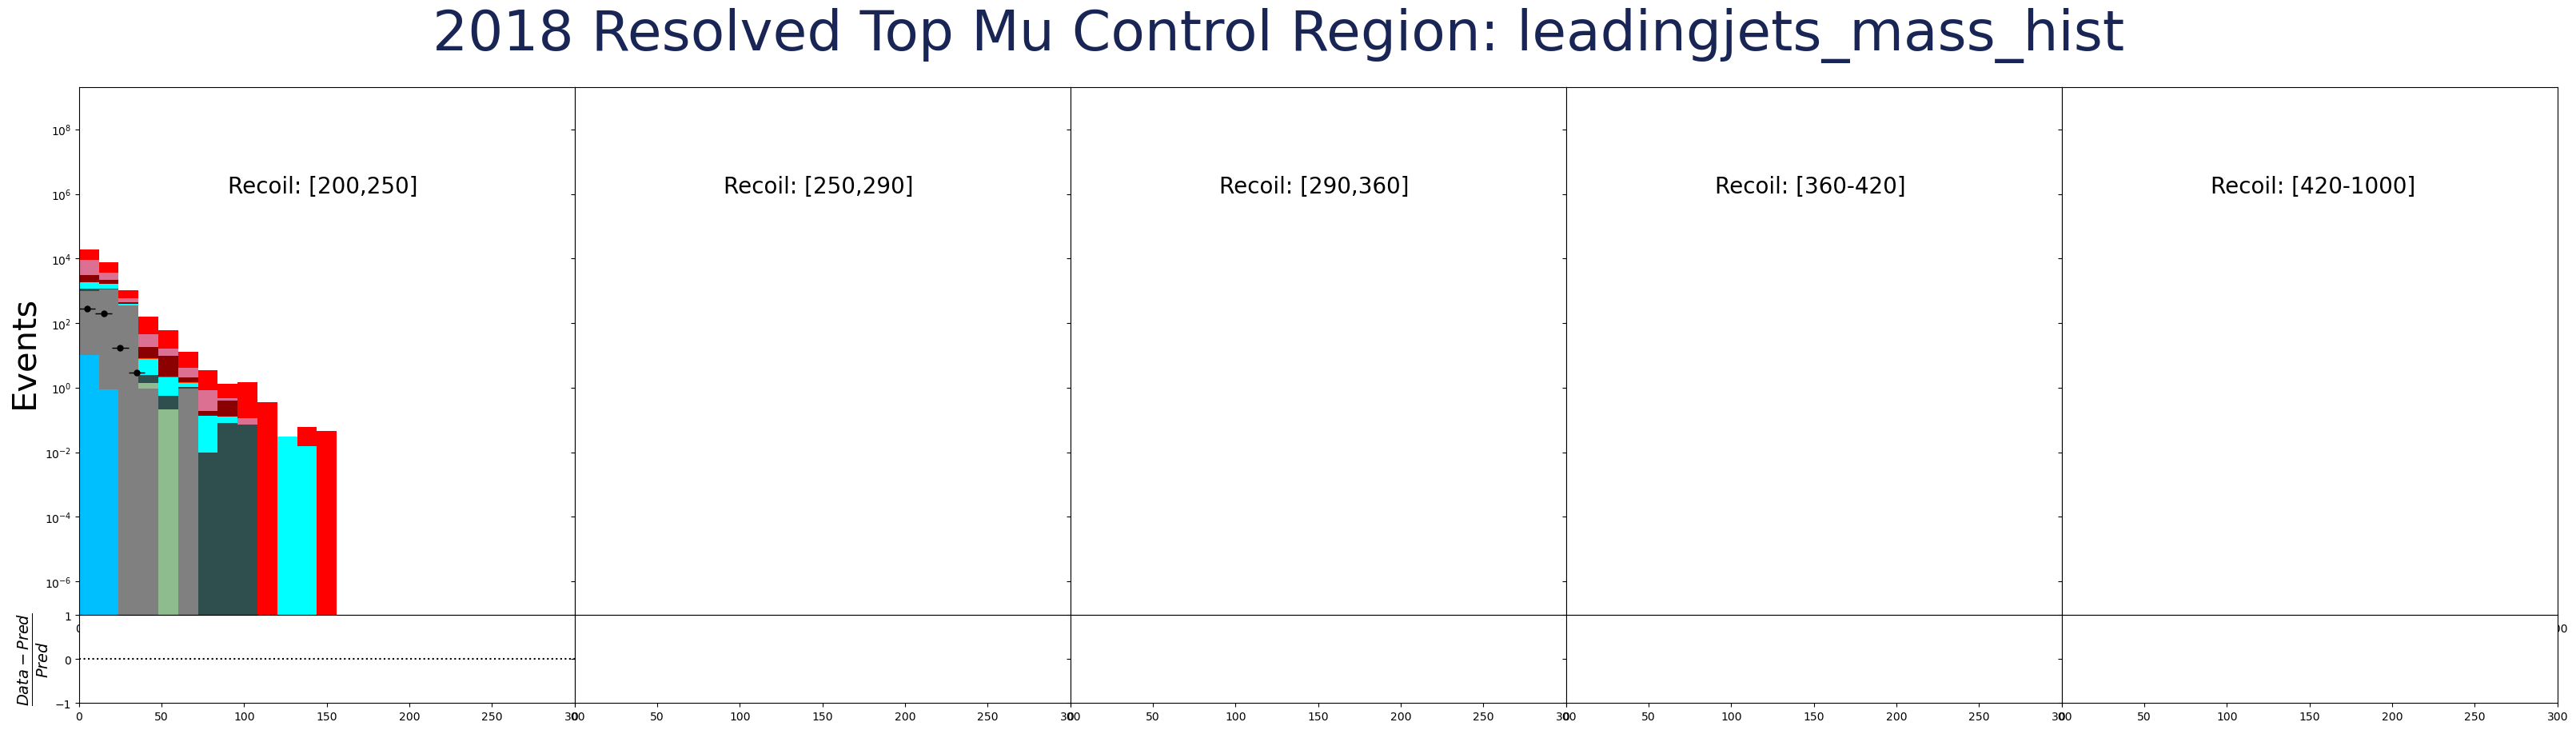